<a href="https://colab.research.google.com/github/IraniS12/202255202004_shilvia-irani-sukri/blob/main/Tugas2_Deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.cm as cm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
base_dir = '/content/drive/MyDrive/Deep learning '
img_size = 224
batch_size = 32

In [ ]:
data_dir = base_dir

train_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=(224, 224),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [ ]:
import pandas as pd
import tensorflow as tf

# Diasumsikan 'data_dir' adalah direktori Anda yang berisi subdirektori untuk setiap kelas
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',  # Label disimpulkan dari nama subdirektori
    label_mode='int',  # Atau 'categorical' jika Anda memiliki label one-hot encoded
    image_size=(img_size, img_size),  # Ubah ukuran gambar ke img_size x img_size
    interpolation='nearest',  # Metode interpolasi untuk mengubah ukuran
    batch_size=batch_size,  # Ukuran batch untuk pemrosesan data
    shuffle=True  # Acak data
)

class_names = dataset.class_names  # Akses nama kelas dari objek dataset
# dataset.imgs mungkin tidak tersedia untuk objek yang dibuat oleh image_dataset_from_directory
# Kita perlu mengambil nama file dan label dengan cara berbeda
image_paths = []
labels = []
for images, batch_labels in dataset:
    for i in range(images.shape[0]):
        image_paths.append(dataset.file_paths[i])  # Mendapatkan path file gambar
        labels.append(batch_labels[i].numpy())  # Mendapatkan label gambar

df = pd.DataFrame({
    'image': image_paths,
    'label': labels
})
print(df.head())

Found 1200 files belonging to 4 classes.
                                               image  label
0  /content/drive/MyDrive/Deep learning /Foto bua...      2
1  /content/drive/MyDrive/Deep learning /Foto bua...      2
2  /content/drive/MyDrive/Deep learning /Foto bua...      0
3  /content/drive/MyDrive/Deep learning /Foto bua...      3
4  /content/drive/MyDrive/Deep learning /Foto bua...      1


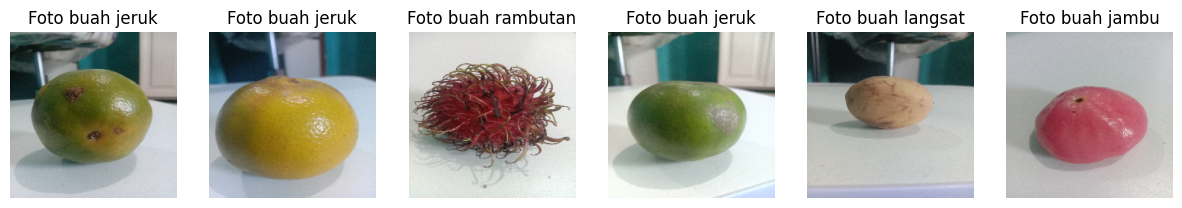

In [ ]:
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    # Ubah dataset menjadi iterator
    dataset_iter = iter(dataset)
    for i in range(num_images):
        # Dapatkan item berikutnya dari iterator
        image, label = next(dataset_iter)
        # Asumsikan image adalah Tensor, ubah ke NumPy array
        image = image.numpy()
        axes[i].imshow(image[0].astype(int)) # Asumsikan gambar pertama dalam batch
        axes[i].set_title(class_names[label[0].numpy()]) # Asumsikan label pertama
        axes[i].axis('off')
    plt.show()

show_images(dataset)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Melatih Model
# Diasumsikan 'df' dari sel sebelumnya berisi path gambar dan label
train_df = df.sample(frac=0.8, random_state=42) # Membagi data menjadi 80% train dan 20% validasi
valid_df = df.drop(train_df.index)

# Convert 'label' column to string type
train_df['label'] = train_df['label'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='image', y_col='label', target_size=(img_size, img_size), # Menggunakan kolom 'image' dan 'label' dari df, dan img_size untuk target_size
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size,
    errors='ignore'  # Abaikan gambar yang rusak
)

# Menggunakan validation_generator, bukan valid_gen
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(valid_df) // batch_size,
    epochs=50
)

Found 960 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 882s 29s/step - accuracy: 0.2608 - loss: 1.6771 - val_accuracy: 0.2768 - val_loss: 1.4274
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 912s 29s/step - accuracy: 0.2484 - loss: 1.5346 - val_accuracy: 0.2679 - val_loss: 1.4201
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 921s 29s/step - accuracy: 0.2471 - loss: 1.4948 - val_accuracy: 0.2857 - val_loss: 1.4107
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 922s 29s/step - accuracy: 0.2331 - loss: 1.5083 - val_accuracy: 0.2723 - val_loss: 1.4046
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 904s 28s/step - accuracy: 0.1990 - loss: 1.4993 - val_accuracy: 0.3482 - val_loss: 1.3979
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 926s 31s/step - accuracy: 0.2672 - loss: 1.4478 - val_accuracy: 0.2634 - val_loss: 1.3959
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 894s 30s/step - accuracy: 0.2585 - loss: 1.4396 - val_accuracy: 0.3036 - val_loss: 1.3889
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 923s 31s/step - accuracy: 0.2619 - loss: 1.4267 - val_accuracy: 0.